In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
from pathlib import Path
import modules.guided_diffusion as gd
from modules.dataset import SpectrumDataset

def create_gaussian_diffusion(
        *,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing="",
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return gd.SpacedDiffusion(
        use_timesteps=gd.space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )

In [2]:

diffusion = create_gaussian_diffusion()
# data_folder = Path(r'C:\Users\sebas\Documents\MATLAB\DataProCiencia\DeepLearning')
data_folder = Path(r'C:\Users\smerino.C084288\Documents\Datasets\ACS')

data = SpectrumDataset(data_folder/'train')
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

BATCH_SIZE = 1
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
from scipy.signal import hilbert
from scipy.io import loadmat
import os

mat_folder = data_folder / 'raw'
mat_file_list = sorted(os.listdir(mat_folder))
extentBm = (-1.905, 1.905, 3.9, 0.0)


##  Version 1

In [30]:
from modules.model import UNETv1
from modules.plotting_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v1')
training_epochs = 30
model1 = UNETv1(in_channels=80,residual=False, attention_res=[]).to(device)
model1.load_state_dict(torch.load(save_dir/f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model1.parameters()))

Num params:  32786625


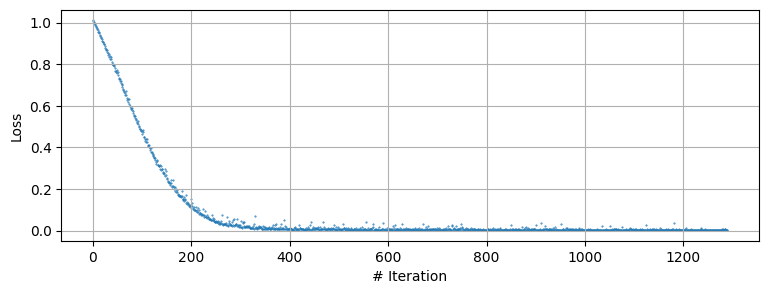

In [32]:

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir/f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.grid()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

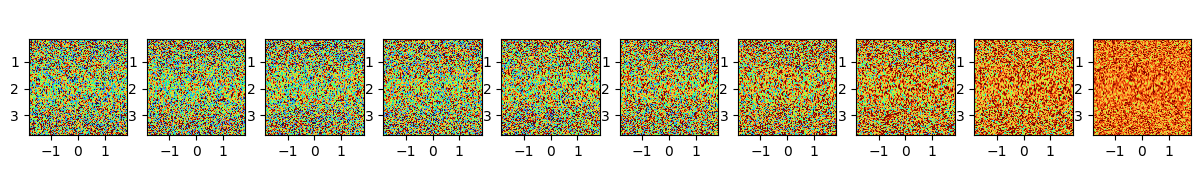

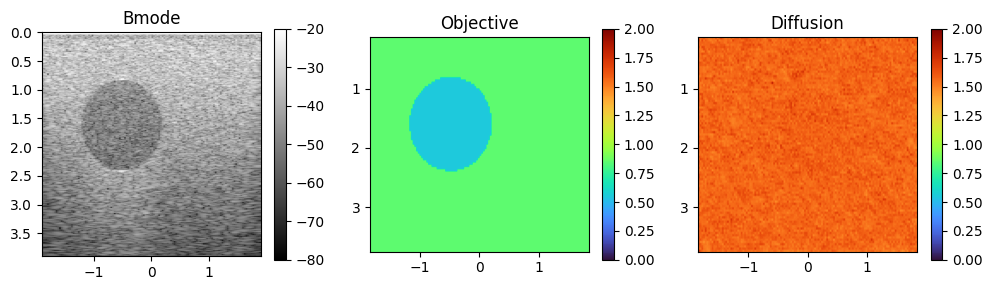

In [6]:
sample_id = 2
x_sample,y_sample = data.__getitem__(sample_id)
x_sample = x_sample.unsqueeze(0)
y_sample = y_sample.unsqueeze(0)

data_dict = loadmat(str(mat_folder / mat_file_list[sample_id]))
rf = data_dict['rf']
Bmode = 20 * np.log10(np.abs(hilbert(rf, axis=0)))
Bmode = Bmode - np.max(Bmode)

intermediate = []
for step in diffusion.p_sample_loop_progressive(model1, y_sample.shape, x_sample, progress=True, clip_denoised=True):
    intermediate.append(step['sample'].cpu().detach())
show_reverse_process(intermediate[::100])

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(Bmode, cmap='gray', extent=extentBm)
plt.clim([-80, -20])
plt.colorbar()
plt.title('Bmode')


plt.subplot(1, 3, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Objective')

plt.subplot(1, 3, 3)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffusion')
plt.show()

## Version 2

Num params:  55719105


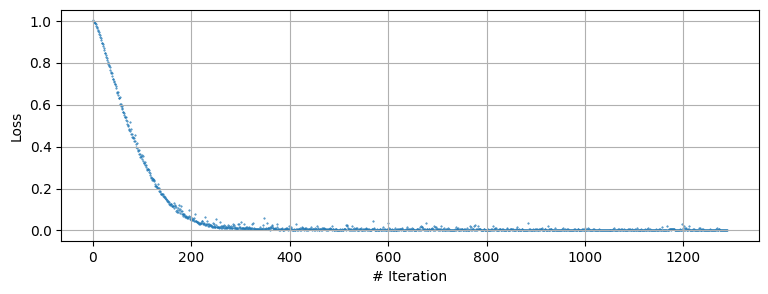

In [33]:
from modules.model import UNETv2
from modules.plotting_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v2')
training_epochs = 30
model2 = UNETv2(in_channels=80, residual=False, attention_res=[]).to(device)
model2.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model2.parameters()))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.grid()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

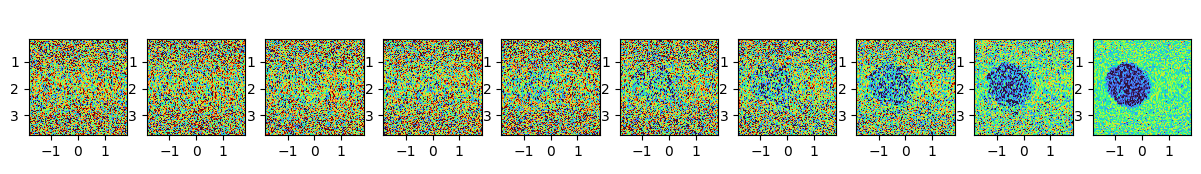

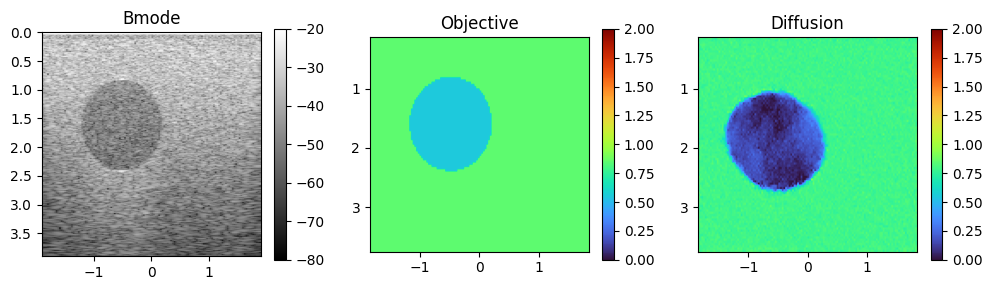

In [34]:
sample_id = 2
x_sample, y_sample = data.__getitem__(sample_id)
x_sample = x_sample.unsqueeze(0)
y_sample = y_sample.unsqueeze(0)

data_dict = loadmat(str(mat_folder / mat_file_list[sample_id]))
rf = data_dict['rf']
Bmode = 20 * np.log10(np.abs(hilbert(rf, axis=0)))
Bmode = Bmode - np.max(Bmode)

intermediate = []
for step in diffusion.p_sample_loop_progressive(model2, y_sample.shape, x_sample, progress=True, clip_denoised=True):
    intermediate.append(step['sample'].cpu().detach())
show_reverse_process(intermediate[::100])

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(Bmode, cmap='gray', extent=extentBm)
plt.clim([-80, -20])
plt.colorbar()
plt.title('Bmode')

plt.subplot(1, 3, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Objective')

plt.subplot(1, 3, 3)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffusion')
plt.show()


# Version 2B: residual

Num params:  58161025


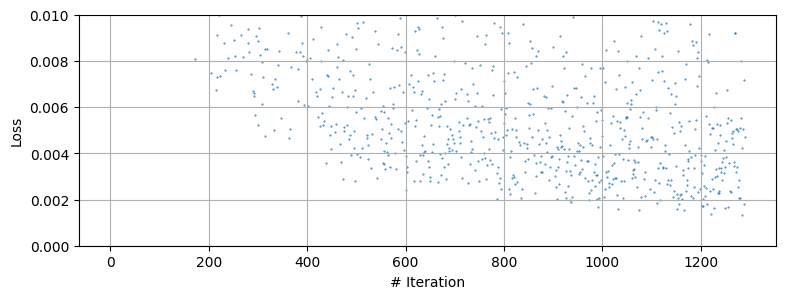

In [18]:
from modules.model import UNETv2
from modules.plotting_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v2B')
training_epochs = 30
model2 = UNETv2(in_channels=80, residual=True, attention_res=[]).to(device)
model2.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model2.parameters()))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0, 0.01)
plt.grid()
plt.show()


In [0]:
sample_id = 2
x_sample, y_sample = data.__getitem__(sample_id)
x_sample = x_sample.unsqueeze(0)
y_sample = y_sample.unsqueeze(0)

data_dict = loadmat(str(mat_folder / mat_file_list[sample_id]))
rf = data_dict['rf']
Bmode = 20 * np.log10(np.abs(hilbert(rf, axis=0)))
Bmode = Bmode - np.max(Bmode)

intermediate = []
for step in diffusion.p_sample_loop_progressive(model2, y_sample.shape, x_sample, progress=True, clip_denoised=True):
    intermediate.append(step['sample'].cpu().detach())
show_reverse_process(intermediate[::100])

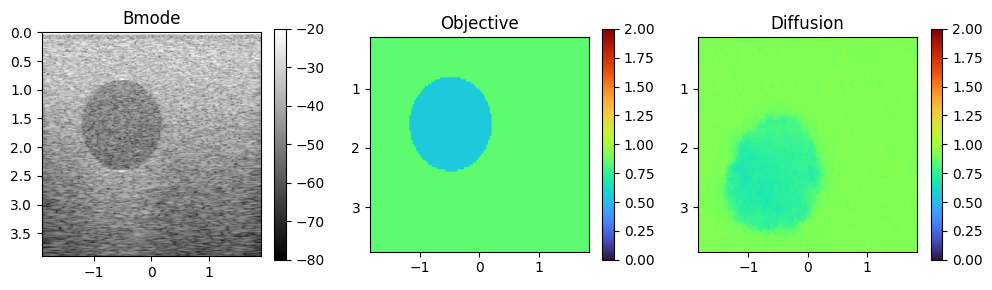

In [17]:

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(Bmode, cmap='gray', extent=extentBm)
plt.clim([-80, -20])
plt.colorbar()
plt.title('Bmode')

plt.subplot(1, 3, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Objective')

plt.subplot(1, 3, 3)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffusion')
plt.show()